# Predicting Ride Counts for a Bike Sharing System

We are going to explore data from a bike sharing system and correlate it with weather data to try to predict demand. This can help the business make important decisions on inventory, staffing, and sales forecasting.

### Prep
The following Python modules need to be available. Instal with pip or conda

* matplotlib - chart visualization
* seaborn - enhancement to charting using matplotlib
* numpy - mathematical and statistics functions
* pandas - data manipulation and exploration
* tensorflow - machine learning

Once installed you can import the libraries and validate that the tensorflow version is 2.x.x

In [145]:
from glob import glob
import os, math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import metrics
from tensorflow.keras.layers.experimental import preprocessing

from sklearn.metrics import r2_score


print(tf.__version__)

2.3.0


In [2]:
# Declare data source and destination paths
raw_data_subdir = 'data\\raw'
weather_file = 'weather2015-2017.csv'
bike_file_suffix = 'capitalbikeshare-tripdata.csv'

clean_data_subdir = 'data\\prepared'
clean_weather_file = 'weather.csv'
clean_transaction_file = 'bike_transactions.csv'
clean_hourly_ride_file = 'hourly_rides.csv'

raw_data_dir = os.path.join(os.getcwd(), raw_data_subdir)
clean_data_dir = os.path.join(os.getcwd(), clean_data_subdir)


# Import the Weather Dataset

Import the dataset. Weather data can be requested from NOAA by filling out the form here: https://www.ncdc.noaa.gov/cdo-web/

The data I selected was the Daily summary for Dulles International Airport in Washington, DC covering years 2015-2017.

This included temperature, precipitation, wind speed and various weather codes that are explained in the NOAA documentation found here https://www1.ncdc.noaa.gov/pub/data/cdo/documentation/GHCND_documentation.pdf


In [3]:
weather_df = pd.read_csv(filepath_or_buffer=os.path.join(raw_data_dir, weather_file),  parse_dates=[1])
# weather_df['DATE'] = weather_df['DATE'].dt.date

# Replace Nulls will 0
weather_df.fillna(0, inplace=True)

##########################################
## Add rename of columns

# View the resulting dataframe
weather_df

,STATION,DATE,AWND,PRCP,SNOW,TAVG,TMAX,TMIN,WT01,WT02,WT03,WT04,WT05,WT06,WT08,WT09
0,USW00093738,2015-01-01,6.93,0.00,0.0,28,42,18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,USW00093738,2015-01-02,0.45,0.00,0.0,32,44,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,USW00093738,2015-01-03,2.01,0.56,0.0,33,38,24,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,USW00093738,2015-01-04,12.75,0.28,0.0,46,60,38,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,USW00093738,2015-01-05,16.11,0.00,0.0,40,46,24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1091,USW00093738,2017-12-27,10.74,0.00,0.0,28,31,17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1092,USW00093738,2017-12-28,8.72,0.00,0.0,18,23,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1093,USW00093738,2017-12-29,4.03,0.00,0.0,19,31,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1094,USW00093738,2017-12-30,6.71,0.03,0.4,24,32,19,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Import the Bike Dataset

Import the datasets. Data Comes from Capital Bikeshare 
https://s3.amazonaws.com/capitalbikeshare-data/index.html
https://www.capitalbikeshare.com/system-data

The files are provided as csvs on a quarterly basis. Instead of manually merging. We can use the pandas library to concatenate the files into a single dataframe.

The data provided details every single bike ride transaction in the Capital Bikeshare system across all stations. This is more detail than we need and we are just trying to find total rides per hour. We modify the timestamp to just include date and hour and then group the transactions by hour to get ride count.

In [4]:
# Import all bikeshare data files in the directory
glob_pattern = os.path.join(raw_data_dir, f"*{bike_file_suffix}")
dfs = [pd.read_csv(f, parse_dates=[1,2])
        for f in glob(glob_pattern)]

# Merge all files into a single dataframe
bike_df = pd.concat(dfs).sort_values(by=['Start date'])


####################
# ADD REMOVAL of DURATION 86394.0 which is approx 60 days


### Group data by hour intervals

Use the groupby function to create a new dataframe that groups all rides by hour

In [5]:
# Truncate timestamp to hour
bike_hourly_df = bike_df.copy()
bike_hourly_df['Timestamp'] = bike_hourly_df['Start date'].dt.floor('h') 

# Get total Rides per hour
bike_hourly_df = bike_hourly_df.groupby(['Timestamp'], as_index = True)['Bike number'].count()

# View the resulting dataframe
bike_hourly_df

Timestamp
2016-01-01 00:00:00     56
2016-01-01 01:00:00    105
2016-01-01 02:00:00     74
2016-01-01 03:00:00     32
2016-01-01 04:00:00     13
                      ... 
2017-12-31 19:00:00     59
2017-12-31 20:00:00     30
2017-12-31 21:00:00     46
2017-12-31 22:00:00     25
2017-12-31 23:00:00     14
Name: Bike number, Length: 17368, dtype: int64

Merge the datasets. They will be merged on Timestamp from the bike date and DATE from the weather data. This is done using the merge_asof function so that an exact match isn't required. Our bike data includes a time component which the weather data does not. We are essentially just matching the Timestamp to any DATE field that is less than or equal, in other words they are on the same date.

In [130]:
# Timestamp in bike_df are hourly, timestamp in weather_df are daily
# Merge on nearest timestamp that is not greater than the Timestamp (i.e same day)

data_df = pd.merge_asof(bike_hourly_df.reset_index(), weather_df, left_on='Timestamp', right_on = 'DATE', direction='backward').set_index(['Timestamp']).rename(columns = {'Bike number':'Ride count'})

data_df.head()

,Ride count,STATION,DATE,AWND,PRCP,SNOW,TAVG,TMAX,TMIN,WT01,WT02,WT03,WT04,WT05,WT06,WT08,WT09
Timestamp,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,56,USW00093738,2016-01-01,8.5,0.0,0.0,42,43,30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-01-01 01:00:00,105,USW00093738,2016-01-01,8.5,0.0,0.0,42,43,30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-01-01 02:00:00,74,USW00093738,2016-01-01,8.5,0.0,0.0,42,43,30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-01-01 03:00:00,32,USW00093738,2016-01-01,8.5,0.0,0.0,42,43,30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-01-01 04:00:00,13,USW00093738,2016-01-01,8.5,0.0,0.0,42,43,30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Feature Engineering

We extrapolate attributes from the dataset to give us additional features (or variables) to use as inputs into our machine learning model. A timestamp may not correlate well with the Ride Count we are trying to predict but by extracting the day of the week we can predict spikes based on whether it is a work day or the weekend. The features I have added are 

* Hour
* Day of week
* Month
* Day of year
* Weekend (boolean flag to denote that it is saturday or sunday)
* Holiday (boolean flag to denote that it is a major holiday that may effect bike demand. This is done by creating a holiday calendar object to account for shifting holidays)
* Season (1 - Spring, 2 - Summer, 3 - Fall, 4 - Winter)

Some of these feature columns will be dropped and not used in our model, but are useful for data analysis to find patterns.

In [131]:
# Add Hour
data_df.insert(3,'Hour', data_df.index.hour)
# Add Day of week
data_df.insert(4,'Day of week', data_df.index.dayofweek)
# Add Month
data_df.insert(5,'Month', data_df.index.month)
# Add Day of year
data_df.insert(6, 'Day of year', data_df.index.dayofyear)
# Add weekend flag
# true if day of week is 5 or 6 (saturday or sunday)
days = [0, 0, 0, 0, 0, 1, 1]
days_to_weekend = dict(zip(range(0,7), days))
data_df.insert(7, 'Weekend', data_df['Day of week'].map(days_to_weekend))
# Add Year
data_df.insert(8,'Year', data_df.index.year)

In [132]:
# Create Holiday Calendar
from pandas.tseries.holiday import AbstractHolidayCalendar, Holiday, \
    nearest_workday, previous_friday, next_monday, \
    USMartinLutherKingJr, USPresidentsDay, USMemorialDay, \
    USLaborDay, USThanksgivingDay

from pandas import DateOffset
from dateutil.relativedelta import FR, MO, SA, SU, TH, TU, WE
import datetime as dt

class USHolidayCalendar(AbstractHolidayCalendar):
    rules = [
        Holiday('NewYearsDay', month=1, day=1, observance=nearest_workday),
        USMartinLutherKingJr,
        USPresidentsDay,
        USMemorialDay,
        Holiday('USIndependenceDay', month=7, day=4, observance=nearest_workday),
        USLaborDay,
        USThanksgivingDay,
        Holiday('DayAfterThanksgiving', month=11, day=1, offset=[DateOffset(weekday=TH(4)), DateOffset(1)]),
        Holiday('ChristmasEve', month=12, day=24, observance=previous_friday),
        Holiday('Christmas', month=12, day=25, observance=next_monday)
    ]


def get_holidays(yearstart, yearend):
    cal = USHolidayCalendar()

    return cal.holidays(dt.datetime(yearstart-1, 12, 31), dt.datetime(yearend, 12, 31))

holidays = get_holidays(2015,2017)

data_df.insert(9,'Holiday',data_df['DATE'].astype(str).isin(holidays.astype(str)).astype(int))


In [133]:
# Add Seasons 
# Winter 1, Spring 2, Summer 3, Fall 4 based on month
seasons = [1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 1]
month_to_season = dict(zip(range(1,13), seasons))
data_df['Season'] = data_df['Month'].map(month_to_season)

In [134]:
# Can drop Date  and station columns after merge and feature engineering. WT09 is 0 for all columns and not needed
data_df.drop(['DATE', 'STATION', 'WT09'], axis=1, inplace=True)

### Output prepared data
The prepared data can be written to a CSV file for reuse or import into a database

In [ ]:
data_df.to_csv(os.path.join(clean_data_dir, clean_hourly_ride_file))
bike_df.to_csv(os.path.join(clean_data_dir, clean_transaction_file))
weather_df.to_csv(os.path.join(clean_data_dir, clean_weather_file))

In [135]:
data_df

,Ride count,Hour,Day of week,Month,Day of year,Weekend,Year,Holiday,AWND,PRCP,...,TMAX,TMIN,WT01,WT02,WT03,WT04,WT05,WT06,WT08,Season
Timestamp,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,56,0,4,1,1,0,2016,1,8.5,0.0,...,43,30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2016-01-01 01:00:00,105,1,4,1,1,0,2016,1,8.5,0.0,...,43,30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2016-01-01 02:00:00,74,2,4,1,1,0,2016,1,8.5,0.0,...,43,30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2016-01-01 03:00:00,32,3,4,1,1,0,2016,1,8.5,0.0,...,43,30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2016-01-01 04:00:00,13,4,4,1,1,0,2016,1,8.5,0.0,...,43,30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-31 19:00:00,59,19,6,12,365,1,2017,0,9.4,0.0,...,21,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2017-12-31 20:00:00,30,20,6,12,365,1,2017,0,9.4,0.0,...,21,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2017-12-31 21:00:00,46,21,6,12,365,1,2017,0,9.4,0.0,...,21,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


# Explore the data

Do some exploratory data analysis to make sure there aren't major anomalies in the data and to find patterns that can help in selecting features that will build the most effective model. Start with basic checks for nulls and any outlying data.

In [63]:
data_df.isnull().sum()

Ride count     0
Hour           0
Day of week    0
Month          0
Day of year    0
Weekend        0
Year           0
Holiday        0
AWND           0
PRCP           0
SNOW           0
TAVG           0
TMAX           0
TMIN           0
WT01           0
WT02           0
WT03           0
WT04           0
WT05           0
WT06           0
WT08           0
Season         0
dtype: int64

In [64]:
data_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Ride count,17368.0,408.323987,390.763603,1.00,77.00,312.00,611.00,1988.00
Hour,17368.0,11.530804,6.915407,0.00,6.00,12.00,18.00,23.00
Day of week,17368.0,3.011861,1.998208,0.00,1.00,3.00,5.00,6.00
Month,17368.0,6.565523,3.426611,1.00,4.00,7.00,10.00,12.00
Day of year,17368.0,184.575484,104.912468,1.00,94.00,185.00,275.00,366.00
Weekend,17368.0,0.287080,0.452412,0.00,0.00,0.00,1.00,1.00
Year,17368.0,2016.503052,0.500005,2016.00,2016.00,2017.00,2017.00,2017.00
Holiday,17368.0,0.027579,0.163769,0.00,0.00,0.00,0.00,1.00
AWND,17368.0,7.220630,3.668343,1.34,4.47,6.26,9.17,24.16
PRCP,17368.0,0.101620,0.280037,0.00,0.00,0.00,0.03,2.82


Then start to explore the date using different charts to compare how different features may effect the Ride count.

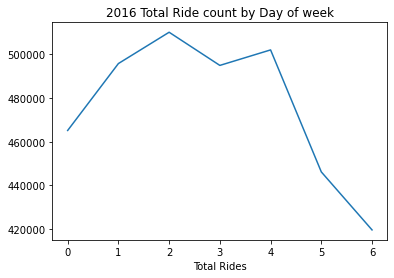

In [127]:
rides_2016 = data_df.where(data_df['Year']==2016)
ridesbyday_bike_df = rides_2016.groupby(['Day of week'], as_index = False)['Ride count'].sum()
x=ridesbyday_bike_df['Day of week']
y=ridesbyday_bike_df['Ride count']
plt.title('2016 Total Ride count by Day of week')
plt.xlabel('Day of week')
plt.xlabel('Total Rides')
plt.plot(x,y)
plt.show()

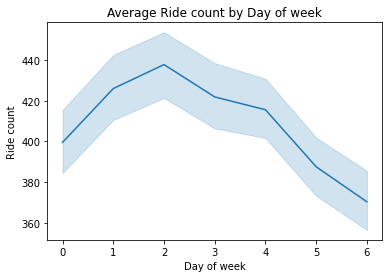

In [128]:
sns.lineplot(data=data_df, x='Day of week',y='Ride count')
plt.title('Average Ride count by Day of week')
plt.show()

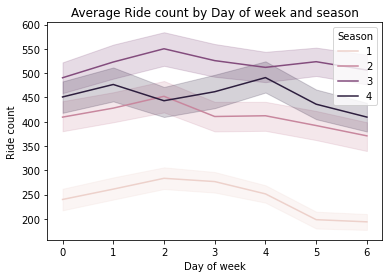

In [136]:
sns.lineplot(data=data_df, x='Day of week',y='Ride count',hue='Season')
plt.title('Average Ride count by Day of week and season')
plt.show()

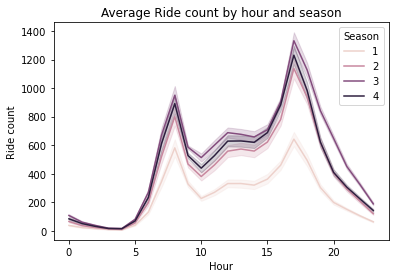

In [137]:
sns.lineplot(data=data_df, x='Hour',y='Ride count',hue='Season')
plt.title('Average Ride count by hour and season')
plt.show()

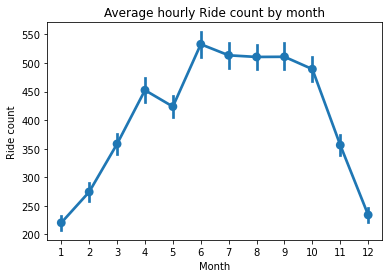

In [138]:
sns.pointplot(data=data_df, x='Month',y='Ride count')
plt.title('Average hourly Ride count by month')
plt.show()

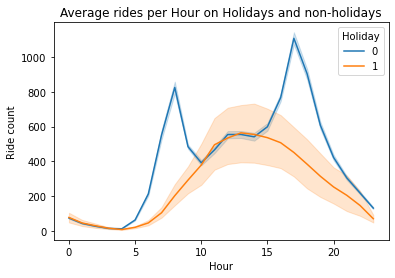

In [139]:
sns.lineplot(data=data_df, x='Hour',y='Ride count',hue='Holiday',color="Or")
plt.title('Average rides per Hour on Holidays and non-holidays')
plt.show()

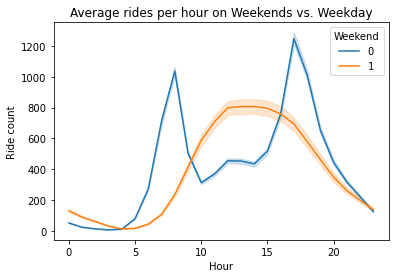

In [140]:
sns.lineplot(data=data_df, x='Hour',y='Ride count',hue='Weekend',color="Or")
plt.title('Average rides per hour on Weekends vs. Weekday')
plt.show()

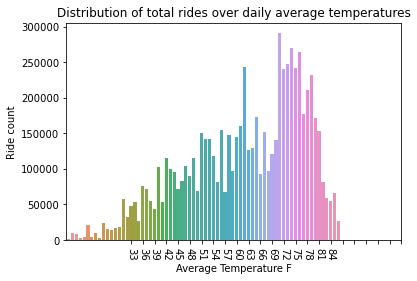

In [141]:
temp_df=data_df.groupby(['TAVG']).sum()
sns.barplot(data=temp_df,x=temp_df.index,y='Ride count')
plt.xticks(rotation=270)
plt.title('Distribution of total rides over daily average temperatures')
plt.xlabel('Average Temperature F')
plt.xticks(np.arange(temp_df.index.min(), temp_df.index.max()+1, 3.0))
plt.show()

Heatmaps and pairplots are another good way of finding correlations in the data. The closer to an absolute value of 1 the more there is correlation. We can see that all features have a 1:1 correlation with themselves and the temperature values are all closely related.  We are looking for correlations with ride count.  These may not be the only items we choose as features as some items may not have a high correlation but are helpful for removing outlying data like the "Holiday" data point.

Pairplots are another good way of viewing correlation between different data.

<AxesSubplot:>

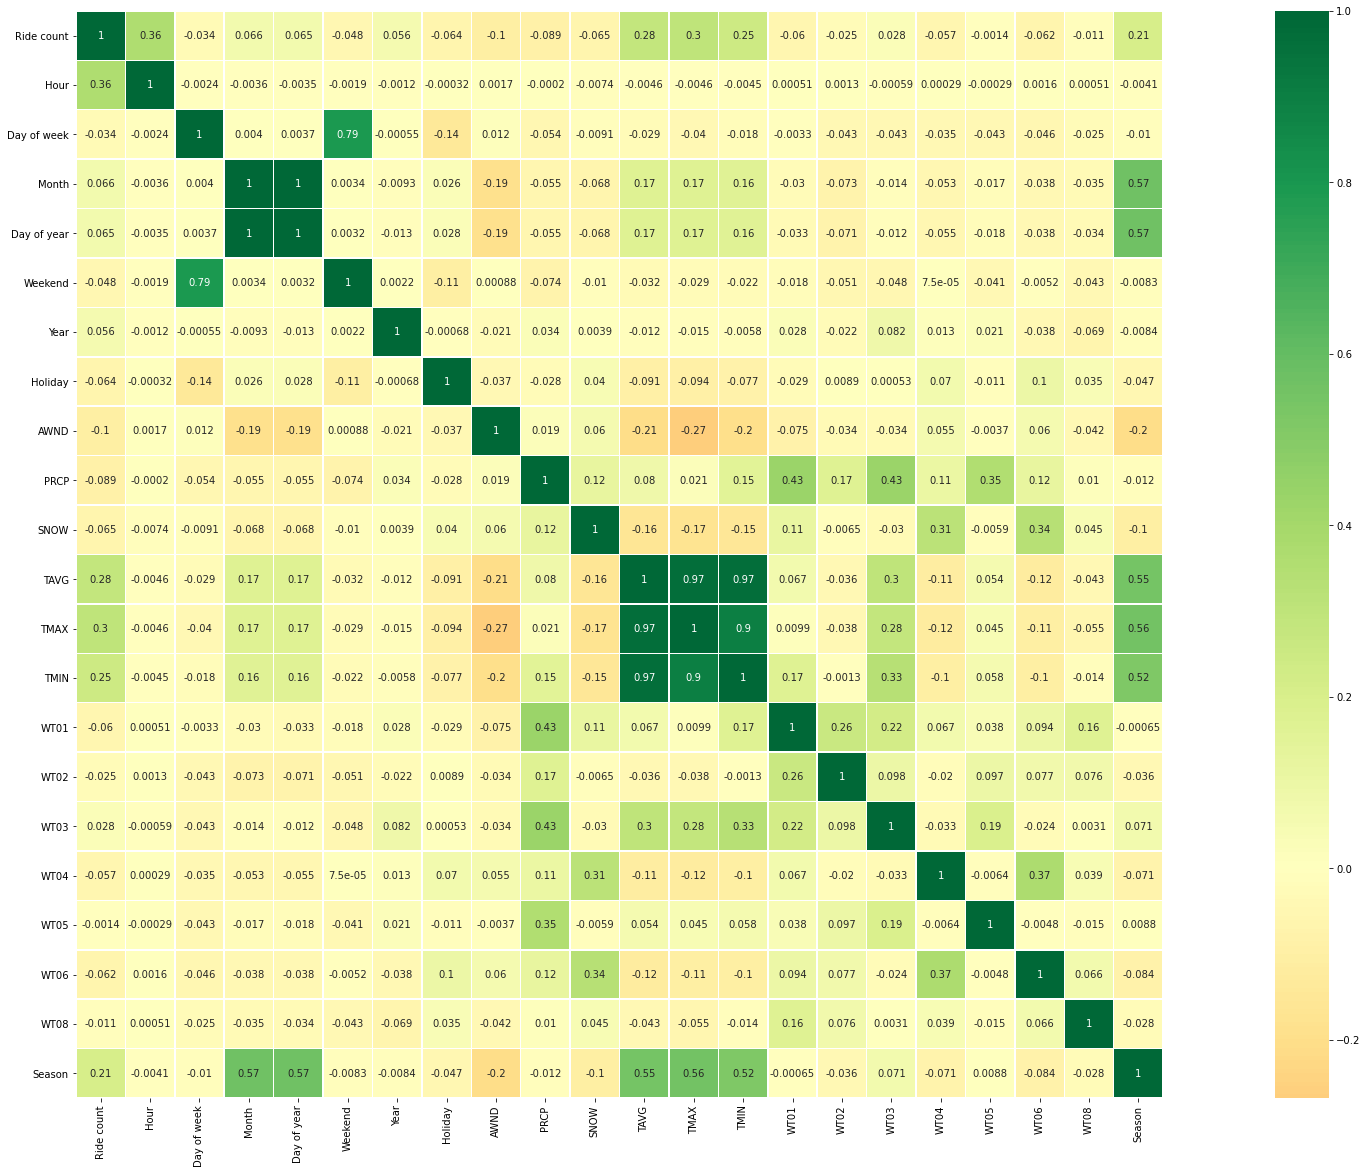

In [142]:
plt.figure(figsize=(40,20))
sns.heatmap(data_df.corr(),square=True,annot=True,linewidths=.5,center=0,cmap="RdYlGn")

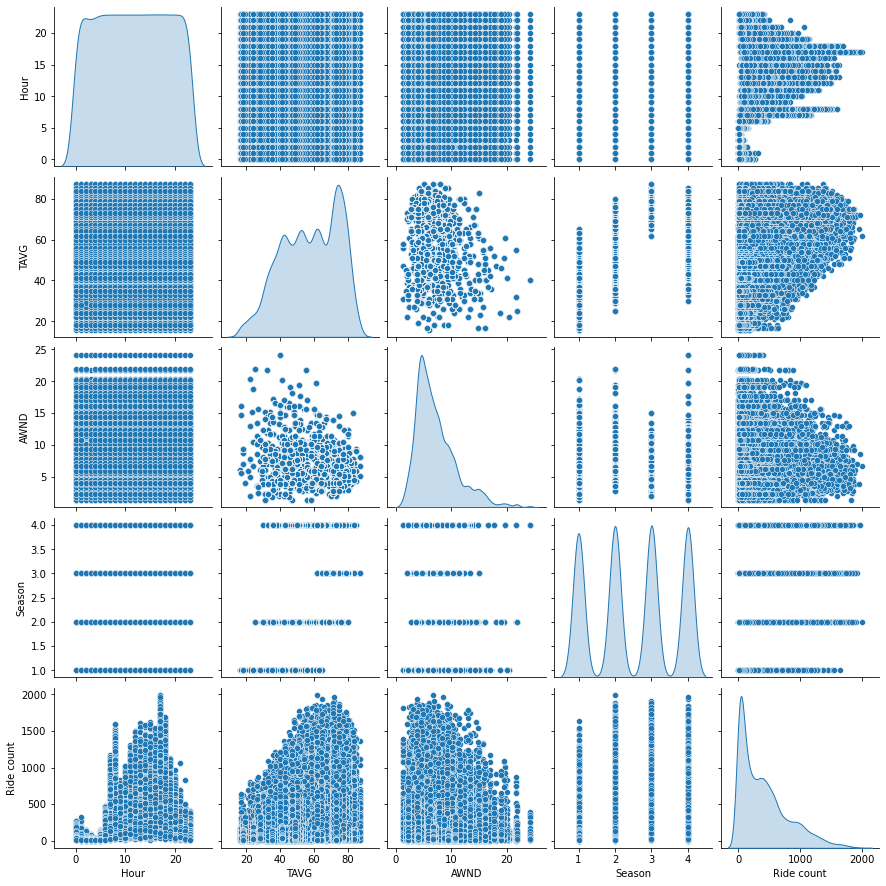

In [143]:
sns.pairplot(data_df[['Hour','TAVG','AWND','Season','Ride count']],diag_kind='kde')

# Prepare data for training the model
To train the model we need to split the data into training and test data. If the model trains on the same data that it is being tested against, it may falsely appear that our model is very accurate but that is only because it is already aware of what the test data looks like. When using this model for a real prediction it might not give us the result we expect. By testing against data that the model has not seen we get a better measure of accuracy.

The training and test data is then split further into date that includes our feaures (or input variables) and labels (or outputs, the thing we want to predict). We have many columns in our source data, so we pick out only the features that we have found will correlate with the output through our analysis.

In [65]:
# Convert Season to one-hot variables
data_df['Season'] = data_df['Season'].map({1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'})
data_df = pd.get_dummies(data_df, prefix='', prefix_sep='', columns=['Season'])

In [66]:
data_df.reset_index(inplace=True)
data_df.drop(['Timestamp'],axis=1, inplace=True)
data_df

,Ride count,Hour,Day of week,Month,Day of year,Weekend,Year,Holiday,AWND,PRCP,...,WT02,WT03,WT04,WT05,WT06,WT08,Fall,Spring,Summer,Winter
0,56,0,4,1,1,0,2016,1,8.5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1
1,105,1,4,1,1,0,2016,1,8.5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1
2,74,2,4,1,1,0,2016,1,8.5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1
3,32,3,4,1,1,0,2016,1,8.5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1
4,13,4,4,1,1,0,2016,1,8.5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17363,59,19,6,12,365,1,2017,0,9.4,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1
17364,30,20,6,12,365,1,2017,0,9.4,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1
17365,46,21,6,12,365,1,2017,0,9.4,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1
17366,25,22,6,12,365,1,2017,0,9.4,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1


In [67]:
# Split data into training and test data
train_df = data_df.sample(frac=0.9, random_state=0)
test_df = data_df.drop(train_df.index)

train_features = train_df.loc[:,['Hour','TMAX','TMIN','Day of week','Month','Holiday','AWND','PRCP','Ride count']]
test_features = test_df.loc[:,['Hour','TMAX','TMIN','Day of week','Month','Holiday','AWND','PRCP','Ride count']]

train_labels = train_features.pop('Ride count')
test_labels = test_features.pop('Ride count')

## Normalize the data

Our features work on different numeric scales. Some are a boolean 1 or 0 and some have much larger ranges for Temperature, Hour, or Wind speed. Normalizing minimizes the effect this may have on our model by converting them to the same range between -1 and 1. A normalizer object is created to keep track of this conversion and is an input into our model.

In [68]:
train_features.describe().transpose()[['mean', 'std', 'min', 'max']]

,mean,std,min,max
Hour,11.519992,6.905141,0.00,23.00
TMAX,67.826499,17.804320,21.00,100.00
TMIN,47.042991,16.920723,7.00,78.00
Day of week,3.018553,1.999754,0.00,6.00
Month,6.559017,3.429570,1.00,12.00
Holiday,0.028149,0.165404,0.00,1.00
AWND,7.225887,3.664297,1.34,24.16
PRCP,0.101040,0.276511,0.00,2.82


In [69]:
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())

[1.1519992e+01 6.7826500e+01 4.7042992e+01 3.0185528e+00 6.5590172e+00
 2.8149191e-02 7.2258868e+00 1.0103960e-01]


In [70]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[ 3.   62.   43.    6.    5.    0.   10.51  0.  ]]

Normalized: [[-1.23 -0.33 -0.24  1.49 -0.45 -0.17  0.9  -0.37]]


# Build and train the model

We are now ready to create our machine learning model and train it to make predictions. We will first define a couple functions to help us create the model and plot the loss (a type of measure for accuracy) to judge how well our model has been trained.

The type of model we are creating uses the keras API and is a sequential model. It uses multiple hiddlen layers of neurons between the input and output layers and is therefore classified as a Deep Neural Network (DNN).

In [119]:
def create_model(normalizer, learning_rate):
  model = keras.Sequential([
      normalizer,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(learning_rate),
                metrics=[
                    metrics.MeanAbsolutePercentageError(name='mean_absolute_percentage_error'),
                    metrics.RootMeanSquaredError(name='root_mean_squared_error')
                ]
    )
  return model

def plot_loss(results):
  plt.plot(results.history['loss'], label='loss')
  plt.plot(results.history['val_loss'], label='val_loss')
  plt.ylim([0, max(results.history['loss'])])
  plt.xlabel('Epoch')
  plt.ylabel('Error [Ride count]')
  plt.legend()
  plt.grid(True)
  plt.show()

def plot_metric(results, metric, color='b'):
  limits = [ 0, max(results.history[metric]), ]
  plt.plot(results.history[metric], label=metric, color=color)
  plt.ylim(limits)
  plt.xlabel('Epoch')
  plt.ylabel('Error [Ride count]')
  plt.legend()
  plt.grid(True)
  plt.show()

In [120]:
learning_rate = 0.009
model = create_model(normalizer, learning_rate)
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 8)                 17        
_________________________________________________________________
dense_15 (Dense)             (None, 64)                576       
_________________________________________________________________
dense_16 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 65        
Total params: 4,818
Trainable params: 4,801
Non-trainable params: 17
_________________________________________________________________


In [121]:
# This statement can be used to reload from a checkpoint if you have saved the model to a file
# dnn_model.load_weights('./models/checkpoint')

## Training
Now that the model is built, we can start training. We use a validation split, that further splits our training data set into training and validation data. In this way the model can check for loss against the validation data to judge how well it is doing during training instead of having to wait until the testing phase.

We also set the number of epochs which are the number of training iterations we will run against the dataset. Batch size determines how many data points are processed at a time.

The results of the training are captured so we can plot the improvement in the loss measurement over the training iterations.

In [122]:
training_results = model.fit(
    train_features, train_labels,
#     steps_per_epoch=1000,
#    batch_size =  16,
    epochs=200,
    validation_split=0.1,
    verbose=1

)

Epoch 1/200
440/440 [==============================] - 1s 1ms/step - loss: 261.8361 - mean_absolute_percentage_error: 294.7361 - root_mean_squared_error: 373.3994 - val_loss: 239.5870 - val_mean_absolute_percentage_error: 268.1430 - val_root_mean_squared_error: 342.6388
Epoch 2/200
440/440 [==============================] - 0s 1ms/step - loss: 193.6209 - mean_absolute_percentage_error: 164.0874 - root_mean_squared_error: 296.5658 - val_loss: 161.7826 - val_mean_absolute_percentage_error: 117.1061 - val_root_mean_squared_error: 251.8252
Epoch 3/200
440/440 [==============================] - 1s 1ms/step - loss: 153.6432 - mean_absolute_percentage_error: 87.0000 - root_mean_squared_error: 250.0281 - val_loss: 141.1203 - val_mean_absolute_percentage_error: 125.8880 - val_root_mean_squared_error: 233.0394
Epoch 4/200
440/440 [==============================] - 0s 884us/step - loss: 139.4707 - mean_absolute_percentage_error: 79.3102 - root_mean_squared_error: 232.1170 - val_loss: 128.5991 - v

440/440 [==============================] - 0s 987us/step - loss: 72.4049 - mean_absolute_percentage_error: 59.3221 - root_mean_squared_error: 113.7012 - val_loss: 73.2887 - val_mean_absolute_percentage_error: 51.0390 - val_root_mean_squared_error: 115.6043
Epoch 31/200
440/440 [==============================] - 0s 1ms/step - loss: 72.5441 - mean_absolute_percentage_error: 60.9013 - root_mean_squared_error: 113.5795 - val_loss: 70.6492 - val_mean_absolute_percentage_error: 62.4865 - val_root_mean_squared_error: 111.8082
Epoch 32/200
440/440 [==============================] - 1s 1ms/step - loss: 71.3624 - mean_absolute_percentage_error: 65.9928 - root_mean_squared_error: 111.9015 - val_loss: 72.6095 - val_mean_absolute_percentage_error: 79.5183 - val_root_mean_squared_error: 114.0116
Epoch 33/200
440/440 [==============================] - 0s 961us/step - loss: 70.6485 - mean_absolute_percentage_error: 59.7266 - root_mean_squared_error: 111.4928 - val_loss: 69.3761 - val_mean_absolute_per

440/440 [==============================] - 1s 1ms/step - loss: 62.8257 - mean_absolute_percentage_error: 48.2838 - root_mean_squared_error: 104.2306 - val_loss: 62.8249 - val_mean_absolute_percentage_error: 46.4897 - val_root_mean_squared_error: 104.3864
Epoch 61/200
440/440 [==============================] - 0s 875us/step - loss: 62.2243 - mean_absolute_percentage_error: 50.0333 - root_mean_squared_error: 102.5551 - val_loss: 61.7438 - val_mean_absolute_percentage_error: 43.9057 - val_root_mean_squared_error: 103.0915
Epoch 62/200
440/440 [==============================] - 0s 1ms/step - loss: 62.9896 - mean_absolute_percentage_error: 51.3043 - root_mean_squared_error: 103.3562 - val_loss: 64.0110 - val_mean_absolute_percentage_error: 46.3400 - val_root_mean_squared_error: 107.0045
Epoch 63/200
440/440 [==============================] - 0s 964us/step - loss: 62.6674 - mean_absolute_percentage_error: 53.0979 - root_mean_squared_error: 102.9988 - val_loss: 61.0171 - val_mean_absolute_per

440/440 [==============================] - 1s 1ms/step - loss: 59.2252 - mean_absolute_percentage_error: 44.4759 - root_mean_squared_error: 99.0784 - val_loss: 67.3515 - val_mean_absolute_percentage_error: 58.1576 - val_root_mean_squared_error: 107.9037
Epoch 91/200
440/440 [==============================] - 1s 1ms/step - loss: 59.7810 - mean_absolute_percentage_error: 47.3604 - root_mean_squared_error: 99.9076 - val_loss: 62.0822 - val_mean_absolute_percentage_error: 56.3324 - val_root_mean_squared_error: 102.2199
Epoch 92/200
440/440 [==============================] - 1s 1ms/step - loss: 59.3410 - mean_absolute_percentage_error: 46.6399 - root_mean_squared_error: 99.3275 - val_loss: 61.9669 - val_mean_absolute_percentage_error: 40.3386 - val_root_mean_squared_error: 104.8844
Epoch 93/200
440/440 [==============================] - 0s 1ms/step - loss: 59.4152 - mean_absolute_percentage_error: 44.2626 - root_mean_squared_error: 99.4390 - val_loss: 60.8997 - val_mean_absolute_percentage_

Epoch 121/200
440/440 [==============================] - 1s 1ms/step - loss: 57.0798 - mean_absolute_percentage_error: 44.4640 - root_mean_squared_error: 96.2353 - val_loss: 61.5579 - val_mean_absolute_percentage_error: 59.0641 - val_root_mean_squared_error: 101.8817
Epoch 122/200
440/440 [==============================] - 1s 1ms/step - loss: 57.4671 - mean_absolute_percentage_error: 44.0538 - root_mean_squared_error: 97.1976 - val_loss: 59.5368 - val_mean_absolute_percentage_error: 41.5262 - val_root_mean_squared_error: 100.7821
Epoch 123/200
440/440 [==============================] - 1s 1ms/step - loss: 57.2663 - mean_absolute_percentage_error: 45.1923 - root_mean_squared_error: 96.9209 - val_loss: 58.7345 - val_mean_absolute_percentage_error: 40.6544 - val_root_mean_squared_error: 102.1310
Epoch 124/200
440/440 [==============================] - 1s 2ms/step - loss: 56.9118 - mean_absolute_percentage_error: 43.1306 - root_mean_squared_error: 95.9619 - val_loss: 58.7529 - val_mean_abs

Epoch 152/200
440/440 [==============================] - 1s 1ms/step - loss: 55.2356 - mean_absolute_percentage_error: 42.6744 - root_mean_squared_error: 93.2237 - val_loss: 58.3655 - val_mean_absolute_percentage_error: 37.7397 - val_root_mean_squared_error: 98.8289
Epoch 153/200
440/440 [==============================] - 1s 1ms/step - loss: 55.3229 - mean_absolute_percentage_error: 41.9575 - root_mean_squared_error: 93.2614 - val_loss: 58.2376 - val_mean_absolute_percentage_error: 44.7303 - val_root_mean_squared_error: 97.8729
Epoch 154/200
440/440 [==============================] - 1s 1ms/step - loss: 55.4950 - mean_absolute_percentage_error: 41.4910 - root_mean_squared_error: 93.8093 - val_loss: 56.3368 - val_mean_absolute_percentage_error: 38.1452 - val_root_mean_squared_error: 95.8740
Epoch 155/200
440/440 [==============================] - 1s 1ms/step - loss: 54.9786 - mean_absolute_percentage_error: 41.8027 - root_mean_squared_error: 93.5143 - val_loss: 57.2521 - val_mean_absolu

Epoch 183/200
440/440 [==============================] - 1s 1ms/step - loss: 53.5515 - mean_absolute_percentage_error: 41.7856 - root_mean_squared_error: 90.8105 - val_loss: 58.3851 - val_mean_absolute_percentage_error: 45.9377 - val_root_mean_squared_error: 96.2106
Epoch 184/200
440/440 [==============================] - 1s 1ms/step - loss: 53.6131 - mean_absolute_percentage_error: 39.4636 - root_mean_squared_error: 91.2411 - val_loss: 57.2616 - val_mean_absolute_percentage_error: 44.5841 - val_root_mean_squared_error: 95.9372
Epoch 185/200
440/440 [==============================] - 1s 1ms/step - loss: 53.9107 - mean_absolute_percentage_error: 39.6306 - root_mean_squared_error: 91.2634 - val_loss: 57.9437 - val_mean_absolute_percentage_error: 39.0981 - val_root_mean_squared_error: 97.3611
Epoch 186/200
440/440 [==============================] - 1s 1ms/step - loss: 53.1392 - mean_absolute_percentage_error: 41.3608 - root_mean_squared_error: 90.6712 - val_loss: 57.2275 - val_mean_absolu

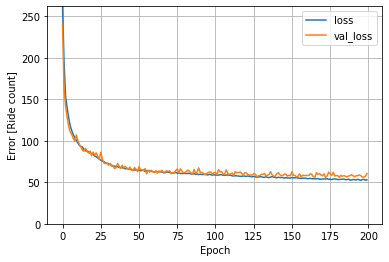

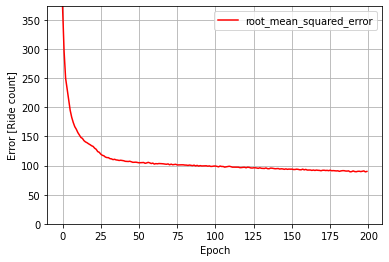

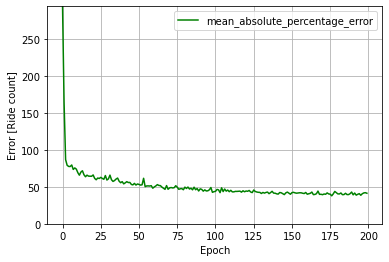

In [123]:
plot_loss(training_results)
plot_metric(training_results, metric='root_mean_squared_error', color='r')
plot_metric(training_results, metric='mean_absolute_percentage_error', color='g' )

# Testing the model

Now that we have a model built. We can test it to see how it performs against the test dataset.

We can then use the model to provide us with Ride count predictions based on the input features.  If we plot the true value from the test data against the predicted value we can see how accurate our model is. We are aiming to fit the diagonal line but overfitting can actually be a problem so if there is outlying data this is not necessarily a failure.

In [124]:
test_results = {}
test_results['model'] = model.evaluate(
    test_features, test_labels,
    verbose=1)

55/55 [==============================] - 0s 673us/step - loss: 59.1665 - mean_absolute_percentage_error: 50.1812 - root_mean_squared_error: 98.2183


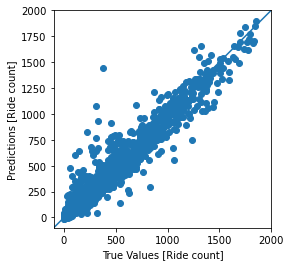

In [125]:
test_predictions = model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [Ride count]')
plt.ylabel('Predictions [Ride count]')
lims = [-100, 2000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

## Evaluating the test results
We can then do further evaluation of our test results to determine if we have a good model. First we will calculate the R2 score for the prediction. Scores closer to 1 are better.

We then plot the difference between predictions and true values.

We will also convert the difference values to a dataframe so we can gather statistical information on the distribution of values and look at the distribution of values. 

In [156]:
r2_score(test_labels.values, test_predictions)

0.9374893802627554

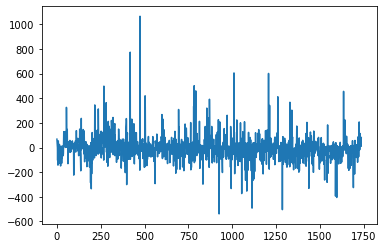

In [163]:
plt.plot(test_predictions - test_labels.values)

plt.show()

In [175]:
differences = test_predictions - test_labels.values
differences = pd.DataFrame(differences, columns=["Difference"])
differences.describe()

Average: -3.2295212053882025


,Difference
count,1737.000000
mean,-3.229521
std,98.193495
min,-538.983673
25%,-41.812988
50%,1.746765
75%,27.316757
max,1065.886108


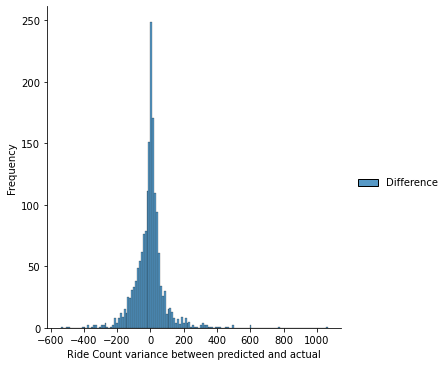

In [183]:
sns.displot(differences)
plt.xlabel("Ride Count variance between predicted and actual")
plt.ylabel("Frequency")
plt.show()

## Saving the model

Once we are satisfied with the model or want to save our progress we can export the model weights to a local file to be restored later for further training. These are just the weights for the inputs based on training and doesn't contain the full model architecture.

The second command will save the entire model including the architecture which is useful for importing into another application.

In [ ]:
# model.save_weights('./models/checkpoint/v1')

In [126]:
model.save('./models/bike_share_v1.0')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./models/bike_share_v1.0\assets


In [ ]:
np.array(test_features.iloc[0:1])

In [ ]:
test_features.iloc[0:1]